In [6]:
import math
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
def f1_score(tp, fp, fn):
    return (2 * tp) / (2 * tp + fp + fn)

def precision_score(tp, fp):
    return tp / (tp + fp)

def accuracy_score(tp, fp, tn, fn):
    return (tp + tn) / (tp + fp + tn + fn)

def recall_score(tp, fn):
    return tp / (tp + fn)

In [55]:
"""
Q4
"""
x_train = np.array([[0,1,0,0],[0,0,0,1],[0,0,1,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,-1]])
y_train = np.array([1,1,1,0,0,0])

model = LogisticRegression(learning_rate=0.001, max_iterations=10000)
model.fit(x_train,y_train)
print(model.weights)
print(model.likelihoods[-1])

"""
LR = 0.001, max_iter = 100
[0, 0, 1, 0] = [0. 0.0165981  1.00893573 0.0165981 ], -3.3616383977067184
[0, 0, 0, 0] = [0. 0.0165981 0.0165981 0.0165981], -4.10978718816732
"""

[0.         1.15606154 1.68096558 1.15606154]
-1.436097546470287


In [8]:
"""
Q5
"""
# fetch dataset 
banknote_authentication = fetch_ucirepo(id=267) 

# data (as pandas dataframes) 
data = banknote_authentication.data
X = data.features
y = data.targets

In [9]:
class GaussianNaiveBayes:
    def __init__(self):
        pass

    def fit(self, X, y):
        xy = data.original.groupby(by='class')
        self.xy_std = xy.std()
        self.xy_mean = xy.mean()
        self.xy_var = xy.var()
        self.p_y = y.value_counts() / len(y)
        self.n_features = X.shape[1]

    def predict(self, X):
        p_yx = pd.DataFrame.from_dict({
            '0': self.probability_yx(X, cls=0),
            '1': self.probability_yx(X, cls=1),
        })
        return np.argmax(p_yx, axis=1)

    def generate(self, n, cls):
        samples = np.random.normal(
            loc=self.xy_mean.iloc[cls],
            scale=self.xy_std.iloc[cls],
            size=(n, self.n_features)
        )
        return samples

    """
    def gaussian_probability(self, X, mu, sigma2):
        a = (1 / np.sqrt(2 * (np.pi) * sigma2))
        b = np.exp(-np.square(X - mu) / (2 * sigma2))
        return a * b
    """

    def probability_xy(self, X, cls):
        a = (1 / (self.xy_std.iloc[cls] * math.sqrt(2 * math.pi)))
        b = np.exp(-((X - self.xy_mean.iloc[cls]) ** 2) / (2 * (self.xy_std.iloc[cls] ** 2)))
        p_xy = a * b
        return p_xy.product(axis=1) 

    def probability_yx(self, X, cls):
        p_xy = self.probability_xy(X, cls)
        p_yx = p_xy * self.p_y.iloc[cls]
        return p_yx
        


In [10]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iterations=1000):
        # init parameters
        self.learning_rate  = learning_rate
        self.max_iterations = max_iterations
        self.likelihoods    = []
        self.eps = 1e-7  # epsilon
        
    def fit(self, X, y):
        # data dimensions
        n_samples = X.shape[0]
        n_features = X.shape[1]
        y_true = y['class'].to_numpy()
        
        # init weights
        self.weights = np.zeros(n_features)
        
        # gradient ascent
        for i in range(self.max_iterations):
            # linear hypothesis
            z = np.dot(X,self.weights)
            
            # probability
            y_hat = self.sigmoid(z)
            
            # gradient
            gradient = np.mean((y_true - y_hat) * X.T, axis=1)
            
            # update weights
            self.weights = self.weights + self.learning_rate * gradient
            
            # log likelihood
            likelihood = self.log_likelihood(y_true, y_hat)
            self.likelihoods.append(likelihood)
            #print(f"i={i}, z={z}, y_pred={y_pred}, gradient={gradient}, weights={self.weights}, likelihood={likelihood}")
    
    def sigmoid(self, z):
        return (1 / (1 + np.exp(-z)))
    
    def log_likelihood(self, y_true, y_hat):
        # fix 0/1 values in y_hat
        y_hat = np.maximum(np.full(y_hat.shape, self.eps), np.minimum(np.full(y_hat.shape, 1 - self.eps), y_hat))

        # log likelihood
        likelihood = sum(y_true * np.log(y_hat) + (1 - y_true) * np.log(1 - y_hat))
        
        return likelihood

    def predict(self, X):
        # linear hypothesis
        z = np.dot(X, self.weights)
        
        # probability 
        y_hat = np.where(self.sigmoid(z) > 0.5, 1, 0)        
        return y_hat

In [7]:
"""
Q5
Part 1
"""
K_FOLDS = 3

k_fold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=777)
models = {
    'gnb': GaussianNaiveBayes(),
    'lr': LogisticRegression(),
}
results = {}

# evaluate the models
for _key in models:
    model = models[_key]
    results[_key] = []
    for train, test in k_fold.split(X, y):
        # split fold into training & testing sets
        X_train, y_train, X_test, y_test = X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test]

        # train the model
        model.fit(X_train, y_train)

        # test the model
        y_hat = model.predict(X_test)

        # evaluate the model
        tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
        results[_key].append({
            'accuracy': accuracy_score(tp=tp, fp=fp, tn=tn, fn=fn),
            'recall': recall_score(tp=tp, fn=fn),
            'precision': precision_score(tp=tp, fp=fp),
            'f1': f1_score(tp=tp, fp=fp, fn=fn),
        })

    # analyze the model results
    results[_key] = pd.DataFrame.from_records(results[_key]).mean()

print("GNB")
print(results['gnb'])
print()
print("LR")
print(results['lr'])

GNB
accuracy     0.840396
recall       0.790198
precision    0.840640
f1           0.814250
dtype: float64

LR
accuracy     0.953362
recall       0.898335
precision    0.996255
f1           0.944574
dtype: float64


In [8]:
"""
Q5
Part 2
"""
training_sizes = [0.01, 0.02, 0.05, 0.1, 0.625, 1.0]
results = []
models = {
    'gnb': GaussianNaiveBayes(),
    'lr': LogisticRegression(),
}

# evaluate the models
for _key in models:
    model = models[_key]
    for t_size in training_sizes:
        for i in range(5):
            # split data for iteration
            if t_size < 1.0:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                    train_size=t_size,
                    test_size=None,
                    random_state=777
                )
                X_test, y_test = X, y  # test on full set each time
            else:
                X_train, X_test, y_train, y_test = X, X, y, y

            # train the model
            model.fit(X_train, y_train)
    
            # test the model
            y_hat = model.predict(X_test)
    
            # evaluate the model
            tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
            results.append({
                'model': _key,
                't_size': t_size,
                'i': i,
                'accuracy': accuracy_score(tp=tp, fp=fp, tn=tn, fn=fn),
                'recall': recall_score(tp=tp, fn=fn),
                'precision': precision_score(tp=tp, fp=fp),
                'f1': f1_score(tp=tp, fp=fp, fn=fn),
            })

# analyze the model results
results_df = pd.DataFrame.from_records(results)
results_df = results_df.groupby(by=['model', 't_size']).mean().drop(columns='i')
print(results_df)

              accuracy    recall  precision        f1
model t_size                                         
gnb   0.010   0.839650  0.795082   0.836207  0.815126
      0.020   0.842566  0.770492   0.860806  0.813149
      0.050   0.844023  0.808197   0.835593  0.821667
      0.100   0.841108  0.791803   0.841463  0.815878
      0.625   0.840379  0.790164   0.841187  0.814877
      1.000   0.841108  0.791803   0.841463  0.815878
lr    0.010   0.932216  0.850820   0.996161  0.917772
      0.020   0.937318  0.872131   0.985185  0.925217
      0.050   0.942420  0.895082   0.973262  0.932536
      0.100   0.946793  0.900000   0.978610  0.937660
      0.625   0.955539  0.900000   1.000000  0.947368
      1.000   0.956268  0.901639   1.000000  0.948276


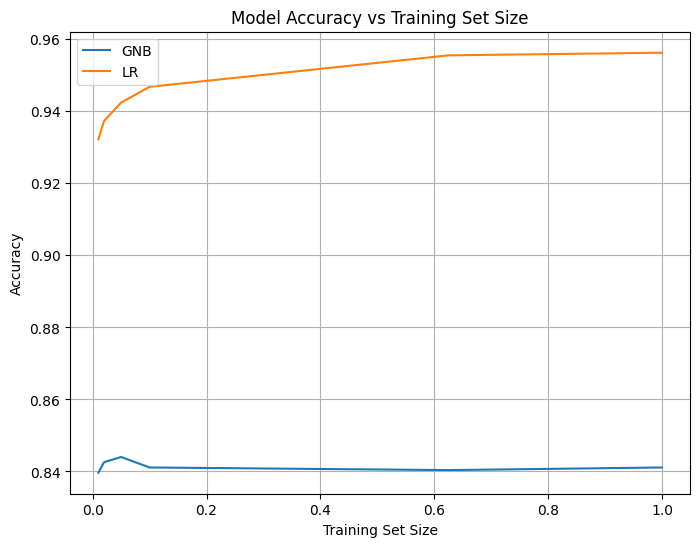

In [43]:
"""
Q5
Part 2
"""
fig, ax = plt.subplots(figsize=(8, 6))
results_df.reset_index().groupby(by='model').plot(
    x='t_size',
    y='accuracy',
    ax=ax,
    kind='line',
    grid=True,
    title="Model Accuracy vs Training Set Size",
    xlabel="Training Set Size",
    ylabel="Accuracy",
)
ax.legend(['GNB', 'LR'])

In [31]:
"""
Q5
Part 3
"""
K_FOLDS = 3
results = []
model = GaussianNaiveBayes()

k_fold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=777)
k_idx = 0
for train, test in k_fold.split(X, y):

    # split fold into training & testing sets
    X_train, y_train, X_test, y_test = X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test]

    # train model
    model.fit(X_train, y_train)
    
    # generate samples
    gen_samples = model.generate(n=400, cls=1)
    gen_df = pd.DataFrame(gen_samples, columns=X_train.columns)

    # gen sample stats
    gen_var = gen_df.var(axis=0)
    gen_mean = gen_df.mean(axis=0)
    gen_var['k_idx'] = k_idx
    gen_mean['k_idx'] = k_idx
    gen_var['data'] = 'generated'
    gen_mean['data'] = 'generated'
    gen_var['stat'] = 'variance'
    gen_mean['stat'] = 'mean'

    # train stats
    train_var = model.xy_var.iloc[1]
    train_mean = model.xy_mean.iloc[1]
    train_var['k_idx'] = k_idx
    train_mean['k_idx'] = k_idx
    train_var['data'] = 'train'
    train_mean['data'] = 'train'
    train_var['stat'] = 'variance'
    train_mean['stat'] = 'mean'
    
    # report stats
    results.append(gen_var)
    results.append(gen_mean)
    results.append(train_var)
    results.append(train_mean)

    # incremenet counter
    k_idx = k_idx + 1
    
# analyze results
results_df = pd.DataFrame.from_records(results).set_index(['k_idx', 'data', 'stat'])
print(results_df)

                          variance   skewness   curtosis   entropy
k_idx data      stat                                              
0.0   generated variance  3.886810  28.475792  24.506623  4.027396
                mean     -1.898866  -1.120628   1.726110 -1.593570
      train     variance  3.538848  29.212768  27.686654  4.288974
                mean     -1.868443  -0.993576   2.148271 -1.246641
1.0   generated variance  3.491784  26.339279  27.118995  4.135338
                mean     -2.058375  -0.839185   1.842334 -1.248411
      train     variance  3.538848  29.212768  27.686654  4.288974
                mean     -1.868443  -0.993576   2.148271 -1.246641
2.0   generated variance  3.330786  24.701685  29.032855  4.210647
                mean     -1.916735  -1.235472   1.731363 -1.120963
      train     variance  3.538848  29.212768  27.686654  4.288974
                mean     -1.868443  -0.993576   2.148271 -1.246641
